# Jobs analytics

EasyApply Bot is a bot that helps you to apply to EasyApply offers on LinkedIn. Here is the project in case you are interested: https://github.com/nicolomantini/LinkedIn-Easy-Apply-Bot

Once you run this program every attempt to apply to a job gets recorded in a CSV file. I've been using the bot for a time and now I want to make some analytics in order to learn something new.

I set up the bot to look for jobs of data scientist, data engineer, data analyst, business intelligence and python.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jobs-applied-in-linkedin-with-easyapplybot/jobs.csv


In [2]:
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
my_filepath = "../input/jobs-applied-in-linkedin-with-easyapplybot/jobs.csv"

my_data = pd.read_csv(my_filepath,encoding='latin1')

my_data.head()

,timestamp,jobID,job,company,attempted,result
0,2020-09-09 18:01:14.040289,1998149634,Data Analytics / Data Scientist,Evolutio Empowering the cloud,True,True
1,2020-09-09 18:01:39.009284,2011446983,Data Scientist,Experis Selecciï¿½n,True,True
2,2020-09-09 18:02:03.471147,2011445130,Data Engineer,SoYou_Bankia,True,True
3,2020-09-09 18:02:18.523716,1990255850,Data Scientist Junior,Strategy Big Data,False,False
4,2020-09-09 18:02:44.209952,2011254160,Data Scientist,Daimler Group Services Madrid,True,True


Since there are some offers that will be constantly visited I will drop all the offers already seen.

In [4]:
non_duplicated = my_data.drop_duplicates(['jobID'])

print("Jobs found: ", len(non_duplicated['result']))
print("Successfully sent applications: ", non_duplicated['result'].value_counts()[1])
print("Failed applications: ", non_duplicated['result'].value_counts()[0])

Jobs found:  124
Successfully sent applications:  82
Failed applications:  42


Now we create two new columns from timestamp column.

In [5]:
import datetime
non_duplicated['date'] = non_duplicated.apply(lambda x: datetime.datetime.strptime(x['timestamp'], '%Y-%m-%d %H:%M:%S.%f').date(), axis = 1)
non_duplicated['time'] = non_duplicated.apply(lambda x: datetime.datetime.strptime(x['timestamp'], '%Y-%m-%d %H:%M:%S.%f').time(), axis = 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Now we can drop timestamp column since it is already useless.

In [6]:
non_duplicated = non_duplicated.drop('timestamp', axis=1)

We can create some other columns related to date. They may be useful in the future.

In [7]:
non_duplicated['day'] = non_duplicated.apply(lambda x: x['date'].day, axis = 1)
non_duplicated['weekday'] = non_duplicated.apply(lambda x: x['date'].weekday(), axis = 1)
non_duplicated['month'] = non_duplicated.apply(lambda x: x['date'].month, axis = 1)

I decided to transform 'attempted' and 'result' fields to be able to plot some graphs.

In [8]:
def convert_result(row):
    if row.result == True:
        row.result = 1
    else:
        row.result = 0
    return row

def convert_att(row):
    if row.attempted == True:
        row.attempted = 1
    else:
        row.attempted = 0
    return row

non_duplicated = non_duplicated.apply(convert_result, axis = 1)
non_duplicated = non_duplicated.apply(convert_att, axis = 1)

In [9]:
non_duplicated.head()

,jobID,job,company,attempted,result,date,time,day,weekday,month
0,1998149634,Data Analytics / Data Scientist,Evolutio Empowering the cloud,1,1,2020-09-09,18:01:14.040289,9,2,9
1,2011446983,Data Scientist,Experis Selecciï¿½n,1,1,2020-09-09,18:01:39.009284,9,2,9
2,2011445130,Data Engineer,SoYou_Bankia,1,1,2020-09-09,18:02:03.471147,9,2,9
3,1990255850,Data Scientist Junior,Strategy Big Data,0,0,2020-09-09,18:02:18.523716,9,2,9
4,2011254160,Data Scientist,Daimler Group Services Madrid,1,1,2020-09-09,18:02:44.209952,9,2,9


Now I group the data per day, counting every attempt and every successful submitting.

In [10]:
group = non_duplicated[['day','attempted', 'result']].groupby(['day']).sum()

group.head()

,attempted,result
day,,
9,16,14
10,15,10
11,13,12
12,6,5
13,7,4


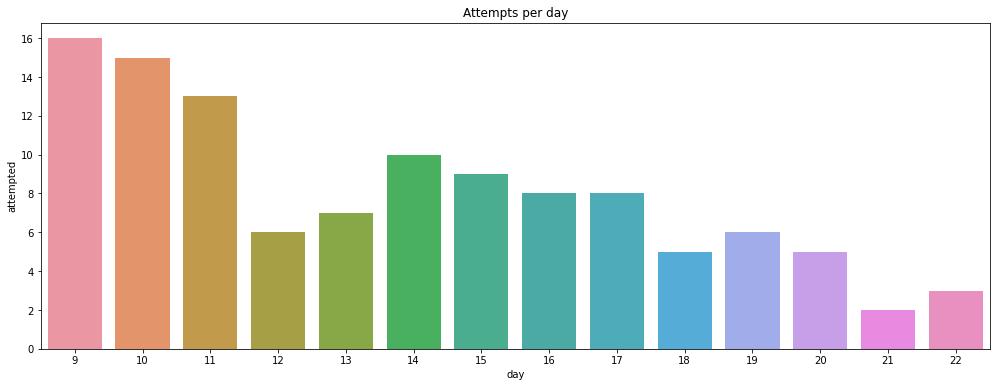

In [11]:
plt.figure(figsize=(17,6))
plt.title("Attempts per day")

sns.barplot(x=group.index, y=group['attempted'])

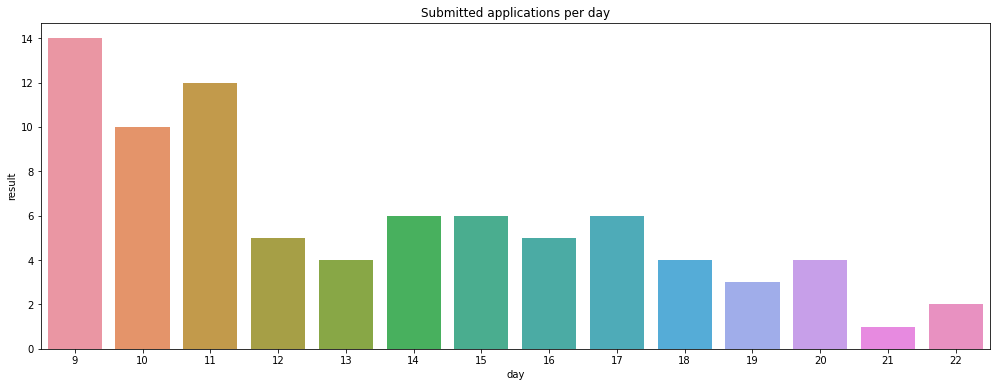

In [12]:
plt.figure(figsize=(17,6))
plt.title("Submitted applications per day")

sns.barplot(x=group.index, y=group['result'])

In [13]:
group2 = non_duplicated[['weekday','attempted', 'result']].groupby(['weekday']).sum()

group2.head()

,attempted,result
weekday,,
0,12,7
1,12,8
2,24,19
3,23,16
4,18,16


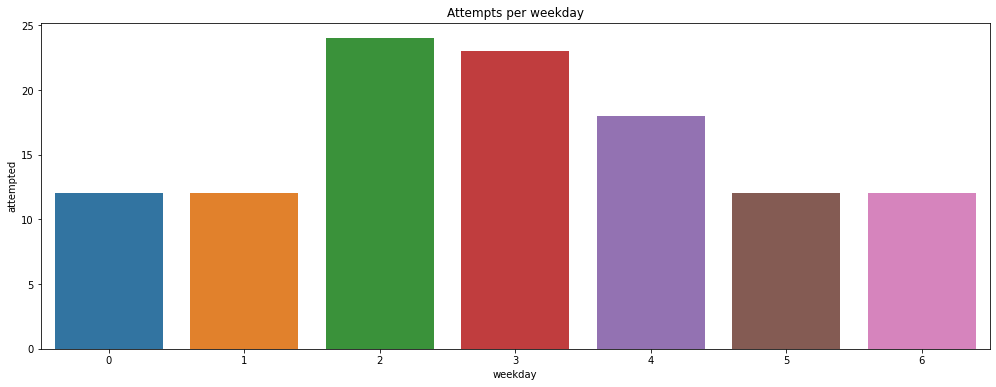

In [14]:
plt.figure(figsize=(17,6))
plt.title("Attempts per weekday")

sns.barplot(x=group2.index, y=group2['attempted'])

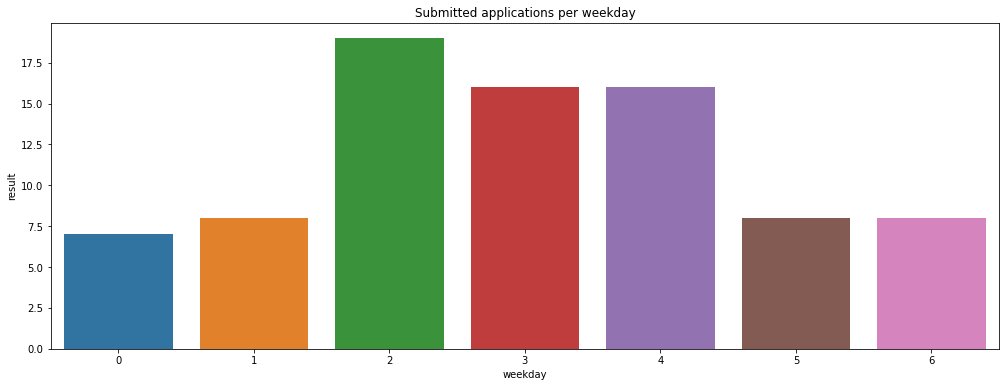

In [15]:
plt.figure(figsize=(17,6))
plt.title("Submitted applications per weekday")

sns.barplot(x=group2.index, y=group2['result'])

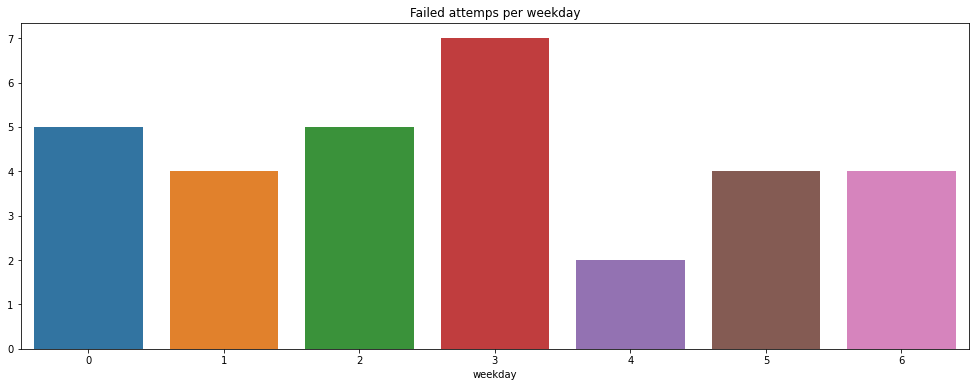

In [16]:
failed = group2['attempted'] - group2['result']

plt.figure(figsize=(17,6))

plt.title("Failed attemps per weekday")

sns.barplot(x=failed.index, y=failed)

It's too soon to make some conclusions since there is still too little data in the dataset. For now, it seems that there are more available jobs in the middle of the week (Wednesday, Thursday, and Friday), but we can't be sure if it is something general or just a coincidence. We'll be watching.

I create another column with the dates when they called me (if so, 'nan' otherwise).

I can take the jobID from the url, so I look for the id of the row in order to change the date_call from 'nan' to the corresponding date of the call.

In [17]:
#2019339369
non_duplicated['date_call'] = np.nan

print(non_duplicated.query('jobID == 2019339369')['date_call']) # id is equal to 92
non_duplicated.loc[92,'date_call'] = datetime.date(2020, 9, 14)

92   NaN
Name: date_call, dtype: float64


Now we can see how many job applications have a response.

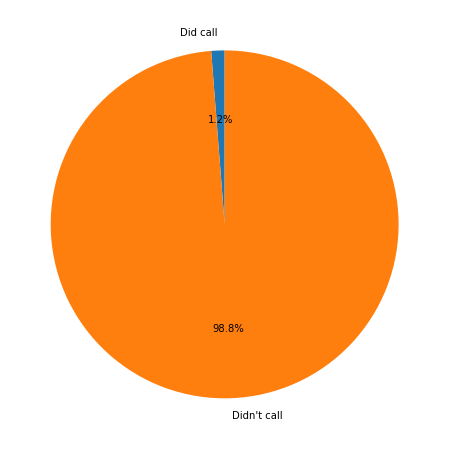

,Total applications,Number of calls
0,82,1


In [18]:
call = non_duplicated['date_call'].notnull().sum()
d_call = non_duplicated['result'].value_counts()[1] - call

p_call = call*100/d_call
p_dcall = 100 - p_call

# Creating dataset 
labels = "Did call", "Didn't call"
  
data = [p_call, p_dcall]
  
# Creating plot 
fig = plt.figure(figsize =(12, 8)) 
plt.pie(data, labels = labels, autopct='%1.1f%%', startangle=90) 
  
# show plot 
plt.show() 

pd.DataFrame({'Total applications':[non_duplicated['result'].value_counts()[1]], 'Number of calls':[call]}).head()


In [19]:
non_duplicated.to_csv('output.csv')

This is all for now. I will be constantly updating this because there is still a lot of interesting information in this data. I will be updating the records too since I'm still looking for a job. 